In [1]:
import pandas
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from glob import glob
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.sandbox.stats.multicomp import multipletests
sys.path.insert(0,'./code/')
import CrossDecomp as XD

# annoyingly, you'll need to clone the git repo from my previous paper because I 
# recycle some code from that repo.
# https://github.com/illdopejake/Hippocampus_AP_Axis

# change this to the location of that repo
sys.path.insert(0,'Hippocampus_AP_Axis/')
import HAP_Utils as hap

In [2]:
%matplotlib inline

# Initialize data

In [3]:
# Where to save figures
fig_dir = './figures/'

In [4]:
# Generated in NB1
bigdf = pandas.read_csv('data/expression.csv') 
allendir = '~/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
gdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
bigdf.index = gdf.index
bigdf.drop('well_id',axis=1,inplace=True)

In [5]:
# recover the PCA results
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf),index = gdf.index)

# Examine components

In [6]:
# fit model to all the data
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [7]:
# Bootstrap PLS model fitting to make bootstrap ratios
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)
n_iter = 1000
bsrx, bsry, allx_bs, ally_bs = XD.bootstrap_features(PLSRegression(n_components=3), 
                                                  pls_mod, 
                                                  pca_tfm, 
                                                  full_y, 
                                                  n_iterations=n_iter,
                                                  mode='rotations')

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


#### Get C1 X Genes

First, let's plot the component loadings including confidence intervals

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

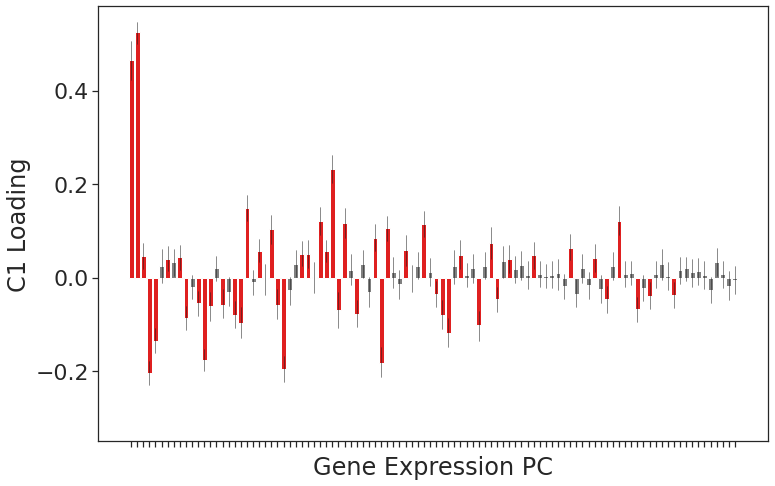

In [8]:
# create plot df
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*n_iter)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=2)
sns.set_style('ticks')

# color based on whether loadings are significantly greater than 0
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]

# plot
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)

# plot confidence intervals
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
    
# decorations
plt.xlabel('Gene Expression PC')
plt.ylabel('C1 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
#plt.savefig(os.path.join(fig_dir,'C1_XWeights.pdf'),bbox_inches='tight')

In [9]:
# manually regularize loadings by setting features to 0 that aren't significantly different from 0
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]

In [10]:
# blast the regularized PLS loadings back into gene space
newc1 = np.dot(pcamod.components_.T, new_loading)
newc1 = pandas.concat([pandas.Series(newc1), pandas.Series(bigdf.columns)],
                      axis=1)
newc1.columns = [0,'gene_symbol']

In [11]:
# create a df with gene symbol and gene name
probe_index = pandas.DataFrame(probes,copy=True)
probe_index.index = probe_index.gene_symbol.values
for i,row in newc1.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc1.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc1.loc[i,'gene_name'] = nm

In [12]:
newc1.sort_values(0,ascending=False)

,0,gene_symbol,gene_name
12808,0.038255,ST3GAL6,"ST3 beta-galactoside alpha-2,3-sialyltransfera..."
7492,0.037735,LXN,latexin
12899,0.033636,STON1,stonin 1
375,0.033044,AIM2,absent in melanoma 2
1865,0.032857,CAVIN3,NaN
...,...,...,...
13807,-0.035313,TNNT2,troponin T type 2 (cardiac)
64,-0.037413,ABHD12B,abhydrolase domain containing 12B
4689,-0.038867,FOXG1,NaN
10446,-0.038939,PRRX1,paired related homeobox 1


In [13]:
# build larger df to collect all C
allcomps = pandas.DataFrame(newc1,copy=True)
allcomps.columns = ['C1','gene_symbol','gene_name']

In [14]:
# get C1 expression for each sample
c1_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc1[0])
gdf.loc[:,'C1_Expression'] = c1_xp

In [15]:
# create a volume with cubes around each coordinate indicating C1 expression at that coordinate
# We'll use this later to do surface analysis

input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'c1'
mni_pth = './data/MNI152_T1_1mm.nii.gz'
wdir = './outputs/'
if not os.path.isdir(wdir):
    os.mkdir(wdir)
gcx_img = hap.make_expression_image(c1_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

#### Get C2 X Genes

Now repeat all those steps with C2

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

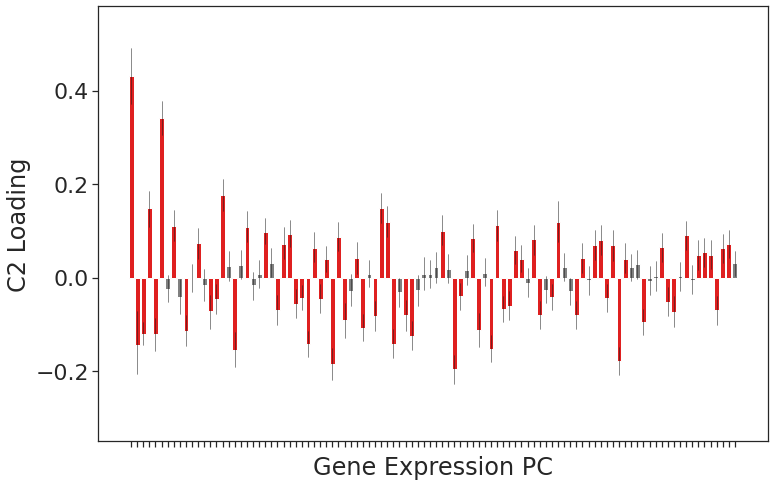

In [16]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*n_iter)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=2)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]]
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
#plt.savefig(os.path.join(fig_dir,'C2_XWeights.pdf'),bbox_inches='tight')

In [17]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
allcomps.loc[:,'C2'] = np.dot(pcamod.components_.T, new_loading)
allcomps.sort_values('C2')

,C1,gene_symbol,gene_name,C2
13280,0.019100,TDRD1,tudor domain containing 1,-0.050843
7856,0.025035,MET,met proto-oncogene (hepatocyte growth factor r...,-0.050050
7936,0.023693,MGP,matrix Gla protein,-0.047736
2820,0.003829,CPLX2,complexin 2,-0.041646
2716,0.014236,COL5A1,"collagen, type V, alpha 1",-0.039550
...,...,...,...,...
5500,-0.006206,HCN4,hyperpolarization activated cyclic nucleotide-...,0.040245
13355,-0.005344,TGFBI,"transforming growth factor, beta-induced, 68kDa",0.044285
489,-0.021527,AMDHD1,amidohydrolase domain containing 1,0.047036
14227,-0.011925,TUNAR,NaN,0.047210


In [18]:
c2_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), allcomps.C2.values)
gdf.loc[:,'C2_Expression'] = c2_xp

In [19]:
nm = 'c2'
mni_pth = './data/MNI152_T1_1mm.nii.gz'
wdir = './outputs/'
if not os.path.isdir(wdir):
    os.mkdir(wdir)
gcx_img = hap.make_expression_image(c2_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

#### Get C3 X Genes

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

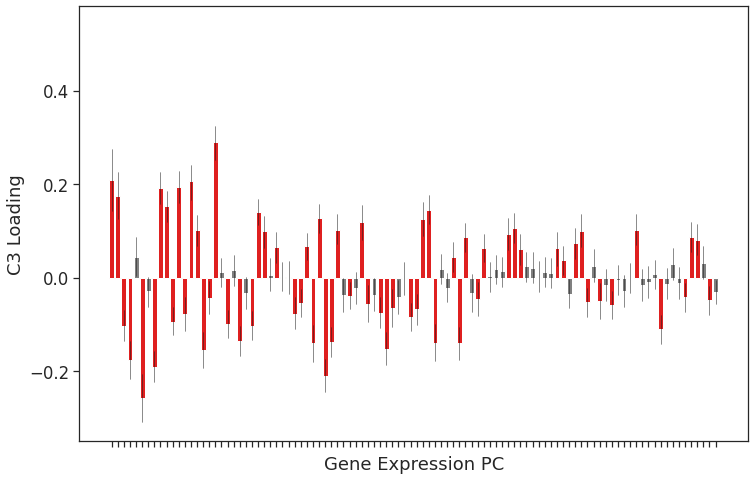

In [20]:
plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*n_iter)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]]
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
plt.xlabel('Gene Expression PC')
plt.ylabel('C3 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
#plt.savefig(os.path.join(fig_dir,'C3_XWeights.pdf'),bbox_inches='tight')

In [21]:
sigs = multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,2] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
allcomps.loc[:,'C3'] = np.dot(pcamod.components_.T, new_loading)
allcomps.sort_values('C3')

,C1,gene_symbol,gene_name,C2,C3
7936,0.023693,MGP,matrix Gla protein,-0.047736,-0.040323
10043,0.001008,PNMT,phenylethanolamine N-methyltransferase,0.013479,-0.039257
11576,0.005951,SAPCD2,NaN,-0.016611,-0.037292
6429,0.006364,KCTD4,potassium channel tetramerisation domain conta...,-0.000514,-0.037083
10552,0.009428,PTGER3,prostaglandin E receptor 3 (subtype EP3),0.022090,-0.036360
...,...,...,...,...,...
11116,-0.025051,RILP,Rab interacting lysosomal protein,-0.002509,0.036615
379,-0.018147,AIRE,autoimmune regulator,0.021581,0.037511
13323,-0.023378,TEX26,testis expressed 26,0.035297,0.038586
4803,-0.016160,G0S2,G0/G1switch 2,-0.001564,0.041783


In [22]:
c3_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), allcomps.C3.values)
gdf.loc[:,'C3_Expression'] = c3_xp

In [23]:
nm = 'c3'
mni_pth = './data/MNI152_T1_1mm.nii.gz'
wdir = './outputs/'
if not os.path.isdir(wdir):
    os.mkdir(wdir)
gcx_img = hap.make_expression_image(c3_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

#### Table S1

In [24]:
allcomps = allcomps.reindex(columns=['gene_symbol','gene_name','C1','C2','C3'])

In [25]:
# ID top 0.83% of genes as significantly contributing
# Thats 5% / two tails = 2.5% / three comparisons = 0.83%
thr = (0.05 / 2) / 3
n_sig = int(round(len(allcomps) * thr))
for col in ['C1','C2','C3']:
    ind = allcomps.sort_values(col,ascending=True).index[:n_sig].tolist() + \
          allcomps.sort_values(col,ascending=False).index[:n_sig].tolist()
    allcomps.loc[ind,'%s_genelist'%col] = 1
    allcomps.loc[allcomps['%s_genelist'%col]!=1,'%s_genelist'%col] = 0
allcomps = allcomps.sort_index()

In [28]:
os.makedirs('./tables/',exist_ok=True)
allcomps.to_csv('./tables/all_comps.csv')

# Projection
Here we will visualize the spatial and genomic components (i.e. the latent variates from the PLS model)

In [29]:
# Fit the the PLS model again
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))
pls_mod = PLSRegression(n_components=3)
#full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

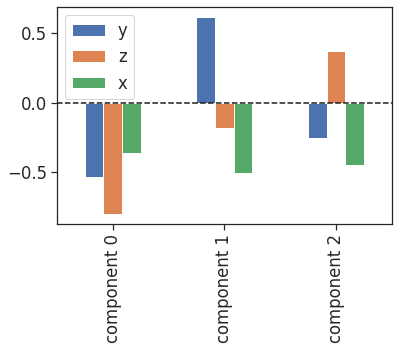

In [31]:
os.makedirs('./figures/',exist_ok=True)
# visualize the y (spatial) weights
sns.set_context('notebook',font_scale=1.5)
pandas.DataFrame(pls_mod.y_weights_, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'y_weights.pdf'),bbox_inches='tight')

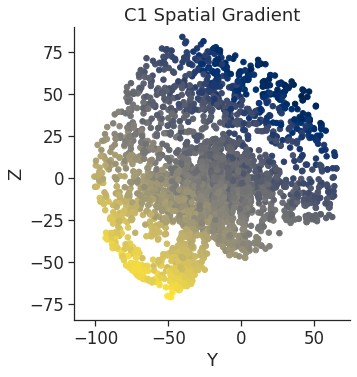

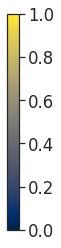

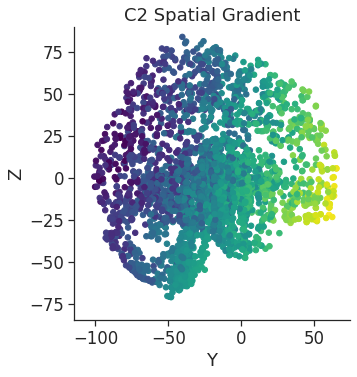

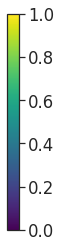

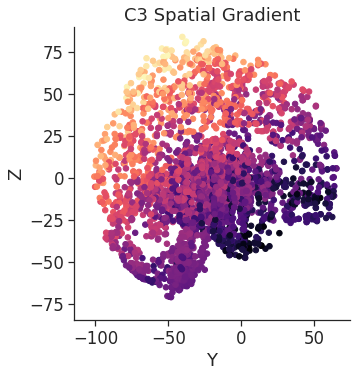

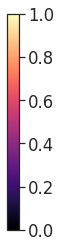

In [32]:
# PLOT SPATIAL GRADIENTS (Latent Y variables)
pals = ['cividis','viridis','magma']

# for each component
for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='magma')
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    #plt.savefig(os.path.join(fig_dir,'brain_plot_SpatialC%s_YZ.png'%(i+1)),
    #            bbox_inches='tight')

    # colorbar
    a = np.array([[0,1]])
    plt.figure(figsize=(.2, 5))
    img = plt.imshow(a, cmap=pals[i])
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    newticks = [round(norm.inverse(x),1) for x in cbar.get_ticks()]
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels(newticks)
    #plt.savefig(os.path.join(fig_dir,'brain_plot_component%s_cbar.png'%(i+1)),
    #                             bbox_inches='tight')

    plt.show()




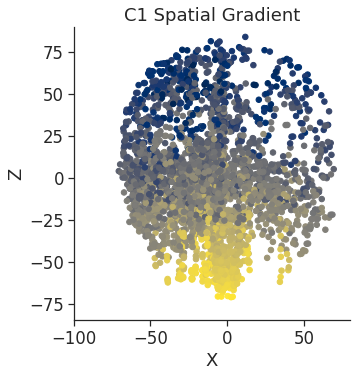

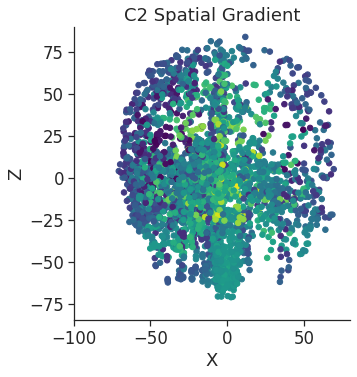

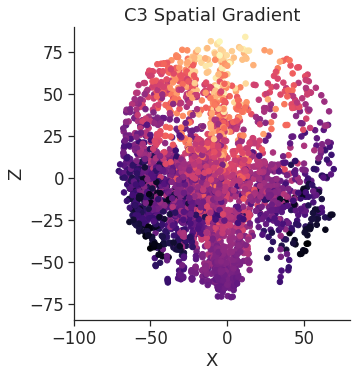

In [33]:
# same thing but from another view
for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='viridis')
    
    # decorate
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig(os.path.join(fig_dir,'brain_plot_SpatialC%s_XZ.png'%(i+1)),
#                 bbox_inches='tight')



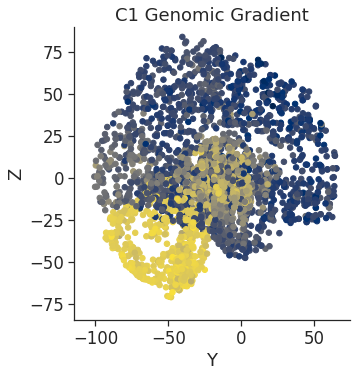

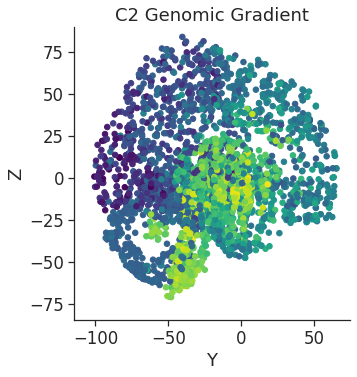

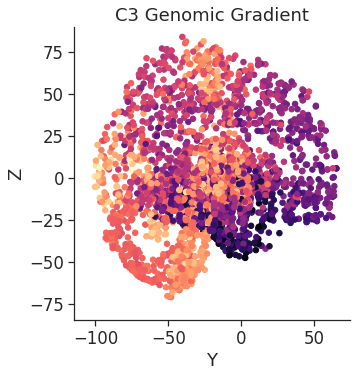

In [34]:
# now the genomic gradients (latent X variables)
sns.set_context('notebook',font_scale=1.5)

# for each component
for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = gdf.loc[:,'C%s_Expression'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  )
    
    # decorate
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    #plt.savefig(os.path.join(fig_dir,'brain_plot_GenomicC%s_YZ.png'%(i+1)),bbox_inches='tight')



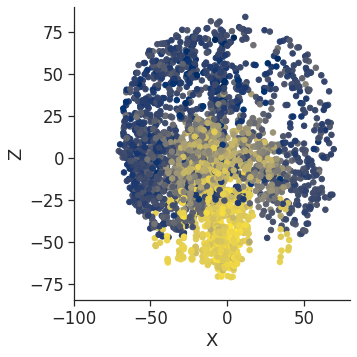

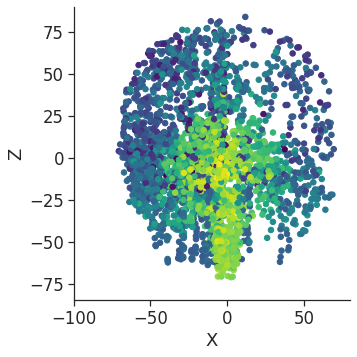

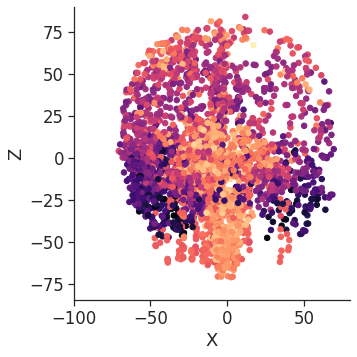

In [35]:
# and the other view

for i in range(pls_mod.y_weights_.shape[0]):
    # colors
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = gdf.loc[:,'C%s_Expression'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    # plot
    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    # decorate
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    #plt.savefig(os.path.join(fig_dir,'brain_plot_GenomicC%s_XZ.png'%(i+1)),bbox_inches='tight')



# Understanding the components

Here we break down the assign each sample to different anatomical category based on their anatomical label. We will explore the relationship between component expression and anatomical information

#### Sample assignment

In [36]:
# first, assign each sample to larger brain regions

Medulla = ['arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                 'central glial substance',
                 'central medullary reticular group, left','central medullary reticular group, right',
                 'cochlear nuclei, left','cochlear nuclei, right',
                 'cuneate nucleus, left','cuneate nucleus, right',
                 'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right',
                 'gigantocellular group, left','gigantocellular group, right',
                 'gracile nucleus, left','gracile nucleus, right',
                 'hypoglossal nucleus, left','hypoglossal nucleus, right',
                 'inferior olivary complex, left','inferior olivary complex, right',
                 'lateral medullary reticular group, left','lateral medullary reticular group, right',
                 'raphe nuclei of medulla',
                 'spinal trigeminal nucleus, left','spinal trigeminal nucleus, right',
                 'superior olivary complex, left','superior olivary complex, right',
                 'vestibular nuclei, left','vestibular nuclei, right']

Pons =          ['abducens nucleus, left','abducens nucleus, right',
                 'central gray of the pons, left','central gray of the pons, right',
                 'facial motor nucleus, left','facial motor nucleus, right',
                 'lateral parabrachial nucleus, left','lateral parabrachial nucleus, right',
                 'locus ceruleus, left','locus ceruleus, right',
                 'medial parabrachial nucleus, left','medial parabrachial nucleus, right',
                 'medial parabrachial nucleus,right',
                 'motor nucleus of trigeminal nerve, left','motor nucleus of trigeminal nerve, right',
                 'nucleus subceruleus, left','nucleus subceruleus, right',
                 'pontine nuclei, left','pontine nuclei, right',
                 'pontine raphe nucleus','pontine raphe nucleus, left',
                 'pontine reticular formation, left','pontine reticular formation, right',
                 'principal sensory nucleus of trigeminal nerve, left','principal sensory nucleus of trigeminal nerve, right',
                 ]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in gdf[gdf.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]

Tectum = ['inferior colliculus, left',
          'superior colliculus, left','superior colliculus, right',
          'pretectal region']

Tegmentum = ['central gray substance of midbrain, left','central gray substance of midbrain, right',
            'cuneiform nucleus, left','cuneiform nucleus, right',
            'Edinger-Westphal nucleus, left','Edinger-Westphal nucleus, right',
            'interstitial nucleus of Cajal, left','interstitial nucleus of Cajal, right',
            'midbrain raphe nuclei','midbrain raphe nuclei, left',
            'midbrain reticular formation, left','midbrain reticular formation, right',
            'nucleus of Darkschewitsch, left',
            'oculomotor nuclear complex, right','oculomotor nuclear complex, left',
            'red nucleus, left','red nucleus, right',
            'subcuneiform nucleus, left','subcuneiform nucleus, right',
            'substantia nigra, pars compacta, left','substantia nigra, pars compacta, right',
            'substantia nigra, pars reticulata, left','substantia nigra, pars reticulata, right',
            'trochlear nucleus, left','trochlear nucleus, right',
            'ventral tegmental area, left','ventral tegmental area, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]
                

Thalamus = ['anterior group of nuclei, left','anterior group of nuclei, right',
           'caudal group of intralaminar nuclei, left','caudal group of intralaminar nuclei, right',
           'dorsal lateral geniculate nucleus, left','dorsal lateral geniculate nucleus, right',
           'lateral group of nuclei, left, dorsal division','lateral group of nuclei, left, ventral division',
           'lateral group of nuclei, right, dorsal division','lateral group of nuclei, right, ventral division',
           'medial geniculate complex, left','medial geniculate complex, right',
           'medial group of nuclei, left','medial group of nuclei, right',
           'reticular nucleus of thalamus, left','reticular nucleus of thalamus, right',
           'rostral group of intralaminar nuclei, left','rostral group of intralaminar nuclei, right',
           'paraventricular nuclei, left of thalamus, left','paraventricular nuclei, right of thalamus, right',
           'posterior group of nuclei, left','posterior group of nuclei, right',
           'subthalamic nucleus, left','subthalamic nucleus, right',
           'zona incerta, left','zona incerta, right']

Other_Dien = ['lateral habenular nucleus, left','lateral habenular nucleus, right',
             'lateral mammillary nucleus, left',
             'lateral tuberal nucleus, left',
             'mammillary body, left','mammillary body, right',
             'medial habenular nucleus, left','medial habenular nucleus, right',
             'medial mammillary nucleus, left',
             'pallidohypothalamic nucleus, left',
             'pineal gland',
             'supramammillary nucleus, left',
             'tuberomammillary nucleus, left']

Limbic = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
          'amygdalohippocampal transition zone, left',
          'amygdalohippocampal transition zone, right',
          'basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
          'dentate gyrus, left','dentate gyrus, right',
          'lateral nucleus, left','lateral nucleus, right',
          'septal nuclei, left','septal nuclei, right',
         'subiculum, left','subiculum, right']

Forebrain = ['basal nucleus of meynert, left','basal nucleus of meynert, right',
            'nucleus accumbens, left','nucleus accumbens, right',
            'nucleus of the diagonal band, left, horizontal division',
            'nucleus of the diagonal band, left, vertical division',
            'olfactory tubercle, left', 'piriform cortex, left',
            'substantia innominata, left','substantia innominata, right']

Striatum = ['bed  nucleus of stria terminalis, left',
            'body of caudate nucleus, left',
            'body of caudate nucleus, right',
            'globus pallidus, external segment, left','globus pallidus, external segment, right',
            'globus pallidus, internal segment, left','globus pallidus, internal segment, right',
            'head of caudate nucleus, left','head of caudate nucleus, right',
            'olfactory tubercle, left',
            'putamen, left','putamen, right',
           'tail of caudate nucleus, left','tail of caudate nucleus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Posterior_Cingulate = ['cingulate gyrus, parietal part, left, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, left, superior bank of gyrus',
                     'cingulate gyrus, parietal part, right, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, right, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, superior bank of gyrus',]

Insula = ['claustrum, left','claustrum, right',
         'long insular gyri, left','long insular gyri, right',
         'short insular gyri, left','short insular gyri, right',]

Temporal = ["Heschl's gyrus, left", "Heschl's gyrus, right",
           'fusiform gyrus, left, bank of cos','fusiform gyrus, left, bank of the its',
           'fusiform gyrus, left, lateral bank of gyrus','fusiform gyrus, right, bank of cos',
           'fusiform gyrus, right, bank of the its','fusiform gyrus, right, lateral bank of gyrus',
           'inferior temporal gyrus, left, bank of mts','inferior temporal gyrus, left, bank of the its',
           'inferior temporal gyrus, left, lateral bank of gyrus','inferior temporal gyrus, right, bank of mts',
           'inferior temporal gyrus, right, bank of the its','inferior temporal gyrus, right, lateral bank of gyrus',
           'middle temporal gyrus, left, inferior bank of gyrus','middle temporal gyrus, left, superior bank of gyrus',
           'middle temporal gyrus, right, inferior bank of gyrus','middle temporal gyrus, right, superior bank of gyrus',
           'occipito-temporal gyrus, left, inferior bank of gyrus','occipito-temporal gyrus, left, superior bank of gyrus',
           'occipito-temporal gyrus, right, inferior bank of gyrus','occipito-temporal gyrus, right, superior bank of gyrus',
           'parahippocampal gyrus, left, bank of the cos','parahippocampal gyrus, left, lateral bank of gyrus',
           'parahippocampal gyrus, right, bank of the cos','parahippocampal gyrus, right, lateral bank of gyrus',
           'superior temporal gyrus, left, inferior bank of gyrus','superior temporal gyrus, left, lateral bank of gyrus',
           'superior temporal gyrus, right, inferior bank of gyrus','superior temporal gyrus, right, lateral bank of gyrus',
           'temporal pole, left, inferior aspect','temporal pole, left, medial aspect',
           'temporal pole, left, superior aspect','temporal pole, right, inferior aspect',
           'temporal pole, right, medial aspect','temporal pole, right, superior aspect',
           'transverse gyri, left','transverse gyri, right',
           'planum polare, left','planum polare, right',
           'planum temporale, left','planum temporale, right']

Parietal = ['angular gyrus, left, inferior bank of gyrus','angular gyrus, left, superior bank of gyrus',
            'angular gyrus, right, inferior bank of gyrus','angular gyrus, right, superior bank of gyrus',
            'precuneus, left, inferior lateral bank of gyrus','precuneus, left, superior lateral bank of gyrus',
            'precuneus, right, inferior lateral bank of gyrus','precuneus, right, superior lateral bank of gyrus',
            'superior parietal lobule, left, inferior bank of gyrus','superior parietal lobule, left, superior bank of gyrus',
            'superior parietal lobule, right, inferior bank of gyrus','superior parietal lobule, right, superior bank of gyrus',
            'supramarginal gyrus, left, inferior bank of gyrus','supramarginal gyrus, left, superior bank of gyrus',
            'supramarginal gyrus, right, inferior bank of gyrus','supramarginal gyrus, right, superior bank of gyrus']

Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Occipital = ['cuneus, left, peristriate',
             'cuneus, left, striate',
             'cuneus, right, peristriate',
             'cuneus, right, striate',
             'inferior occipital gyrus, left, inferior bank of gyrus','inferior occipital gyrus, left, superior bank of gyrus',
             'inferior occipital gyrus, right, inferior bank of gyrus','inferior occipital gyrus, right, superior bank of gyrus',
             'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
             'lingual gyrus, right, peristriate','lingual gyrus, right, striate',
             'occipital pole, left, inferior aspect',
             'occipital pole, left, lateral aspect','occipital pole, left, superior aspect',
             'superior occipital gyrus, left, inferior bank of gyrus','superior occipital gyrus, left, superior bank of gyrus',
             'superior occipital gyrus, right, inferior bank of gyrus','superior occipital gyrus, right, superior bank of gyrus',]

Sensorimotor = ['paracentral lobule, anterior part, left','paracentral lobule, anterior part, left, inferior bank of gyrus',
                'paracentral lobule, anterior part, left, superior bank of gyrus','paracentral lobule, anterior part, right, inferior bank of gyrus',
                'paracentral lobule, anterior part, right, superior bank of gyrus','paracentral lobule, posterior part, left, bank of cingulate sulcus',
                'paracentral lobule, posterior part, left, lateral bank of gyrus','paracentral lobule, posterior part, right, bank of cingulate sulcus',
                'paracentral lobule, posterior part, right, lateral bank of gyrus',
                'postcentral gyrus, left, bank of the central sulcus','postcentral gyrus, left, bank of the posterior central sulcus',
                'postcentral gyrus, left, inferior lateral aspect of gyrus','postcentral gyrus, left, superior lateral aspect of gyrus',
                'postcentral gyrus, right, bank of the central sulcus','postcentral gyrus, right, bank of the posterior central sulcus',
                'postcentral gyrus, right, inferior lateral aspect of gyrus','postcentral gyrus, right, superior lateral aspect of gyrus',
                'precentral gyrus, left, bank of the central sulcus','precentral gyrus, left, bank of the precentral sulcus',
                'precentral gyrus, left, inferior lateral aspect of gyrus','precentral gyrus, left, superior lateral aspect of gyrus',
                'precentral gyrus, right, bank of the central sulcus','precentral gyrus, right, bank of the precentral sulcus',
                'precentral gyrus, right, inferior lateral aspect of gyrus','precentral gyrus, right, superior lateral aspect of gyrus']
            
divs = [Medulla, Pons, DCN, Cerebellum, Tectum, Tegmentum, Hypothalamus, Thalamus, Other_Dien,
                  Limbic, Forebrain, Striatum, Anterior_Cingulate, Posterior_Cingulate, Insula,
                  Temporal, Frontal, Parietal, Occipital, Sensorimotor]
names = ['Medulla', 'Pons', 'DCN', 'Cerebellum', 'Tectum', 'Tegmentum', 'Hypothalamus', 'Thalamus', 
         'Other_Dien', 'Limbic', 'Forebrain', 'Striatum', 'Anterior_Cingulate', 'Posterior_Cingulate', 
         'Insula', 'Temporal', 'Frontal', 'Parietal', 'Occipital', 'Sensorimotor']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name
    

In [37]:
# For C1 -- which segment of the neural tube does the region originate from
Meyelencephalon = Medulla[:] 
Metencelphalon = Pons + DCN + Cerebellum
Mesencephalon = Tectum + Tegmentum
Diencephalon = Hypothalamus + Thalamus + Other_Dien
Telencephalon = Limbic + Forebrain + Striatum + Anterior_Cingulate + Posterior_Cingulate +\
                Insula + Temporal + Frontal + Parietal + Occipital + Sensorimotor

divs = [Meyelencephalon, Metencelphalon, Mesencephalon, Diencephalon, Telencephalon]
names = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Neural_Tube_segment'] = name
    

In [38]:
# For C3 -- what kind of cortex does the sample belong to

Auditory = ["Heschl's gyrus, left", "Heschl's gyrus, right",
            'planum polare, left','planum polare, right',
            'planum temporale, left','planum temporale, right',
            'transverse gyri, left','transverse gyri, right']
Visual = ['cuneus, left, peristriate','cuneus, left, striate',
                 'cuneus, right, peristriate','cuneus, right, striate',
                 'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
                 'lingual gyrus, right, peristriate','lingual gyrus, right, striate']
Olfactory = ['olfactory tubercle, left', 'piriform cortex, left']


Sensory_Cortex = Sensorimotor + Auditory + Visual + Olfactory
gdf.loc[gdf[gdf.structure_name.isin(Sensory_Cortex)].index,'Cortical_Type'] = 'Sensory'

Association_Cortex = [x for x in Telencephalon if x not in Striatum and x not in Sensory_Cortex]
gdf.loc[gdf[gdf.structure_name.isin(Association_Cortex)].index,'Cortical_Type'] = 'Association_Cortex'

Cerebellar_Cortex = [x for x in Cerebellum]
gdf.loc[gdf[gdf.structure_name.isin(Cerebellar_Cortex)].index,'Cortical_Type'] = 'Cerebellar_Cortex'

Not_Cortex = Meyelencephalon + Mesencephalon + Pons + DCN + Diencephalon + Striatum
gdf.loc[gdf[gdf.structure_name.isin(Not_Cortex)].index,'Cortical_Type'] = 'Not Cortex'


divs = [Auditory, Visual, Olfactory, Sensorimotor, Association_Cortex, Not_Cortex, Cerebellar_Cortex]
names = ['Auditory','Visual','Olfactory','Sensorimotor','Association_Cortex','Not_Cortex','Cerebellar_Cortex']
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Sensory_Type'] = name


In [39]:
# for c2 -- does the sample's region originate from the dorsal or ventral aspect of the neural tube
alar_medulla = ['spinal trigeminal nucleus, right', 'spinal trigeminal nucleus, left',
               'cochlear nuclei, left','cochlear nuclei, right',
               'vestibular nuclei, left','vestibular nuclei, right',
               'inferior olivary complex, left','inferior olivary complex, right',
                'gracile nucleus, left','gracile nucleus, right',
               'cuneate nucleus, left','cuneate nucleus, right',
               'superior olivary complex, left','superior olivary complex, right',]

basal_medulla = ['hypoglossal nucleus, left','hypoglossal nucleus, right',
                'lateral medullary reticular group, left','lateral medullary reticular group, right',
                'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right', 
                'arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                'central medullary reticular group, left','central medullary reticular group, right',
                'raphe nuclei of medulla',
                'gigantocellular group, left','gigantocellular group, right', ]


divs = [alar_medulla, basal_medulla]
names = ['Alar_Medulla','Basal_Medulla']
med_division = dict(zip(names,divs))

for name, div in med_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name

dorsal_plate = ['Cerebellum', 'Thalamus', 'Tectum', 'Alar_Medulla']
ventral_plate = ['Hypothalamus','Pons','Tegmentum','Basal_Medulla']
subcortical = ['Forebrain', 'Striatum', 'Limbic']
frontal = ['Anterior_Cingulate','Insula','Frintal']
temporal = ['Temporal']
somatomotor = ['Sensorimotor']
parietal = ['Parietal']
occipital = ['Occipital']

gdf.loc[gdf[gdf.brain_divison.isin(dorsal_plate)].index,'Neural_Plate'] = 'Dorsal'
gdf.loc[gdf[gdf.brain_divison.isin(ventral_plate)].index,'Neural_Plate'] = 'Ventral'
gdf.loc[gdf[gdf.brain_divison.isin(subcortical)].index,'Neural_Plate'] = 'Subcortical'
gdf.loc[gdf[gdf.brain_divison.isin(frontal)].index,'Neural_Plate'] = 'Frontal'
gdf.loc[gdf[gdf.brain_divison.isin(temporal)].index,'Neural_Plate'] = 'Temporal'
gdf.loc[gdf[gdf.brain_divison.isin(somatomotor)].index,'Neural_Plate'] = 'Somatomotor'
gdf.loc[gdf[gdf.brain_divison.isin(parietal)].index,'Neural_Plate'] = 'Parietal'
gdf.loc[gdf[gdf.brain_divison.isin(occipital)].index,'Neural_Plate'] = 'Occipital'


In [40]:
# for GTeX

gfrontal = Frontal
gAC = Anterior_Cingulate
gCereb = Cerebellum
gHT = Hypothalamus
gCaud = ['body of caudate nucleus, left',
         'body of caudate nucleus, right',
        'head of caudate nucleus, left',
         'head of caudate nucleus, right',
        'tail of caudate nucleus, left',
         'tail of caudate nucleus, right']
gPut = ['putamen, left','putamen, right',]
gGP = ['globus pallidus, external segment, left',
       'globus pallidus, external segment, right',
       'globus pallidus, internal segment, left',
       'globus pallidus, internal segment, right',]
gAmyg = ['basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
        'lateral nucleus, left','lateral nucleus, right']
gHipp = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
         'dentate gyrus, left','dentate gyrus, right',
        'subiculum, left','subiculum, right']
sn = ['substantia nigra, pars compacta, left',
      'substantia nigra, pars compacta, right',
      'substantia nigra, pars reticulata, left',
      'substantia nigra, pars reticulata, right']
gNAcc = ['nucleus accumbens, left','nucleus accumbens, right',]

divs = [gfrontal, gAC, gCereb, gHT, gCaud, gPut, gGP, gAmyg, 
        gHipp,sn,gNAcc]
names = ['Frontal', 'AntCing', 'Cerebellum', 'Hypothalamus', 
         'Caudate','Putamen','Pallidum','Amygdala','Hippocampus',
        'Nigra','Accumbens']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'GTeX_div'] = name
    

#### Plotting associations

/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 15.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Component 1 Expression')

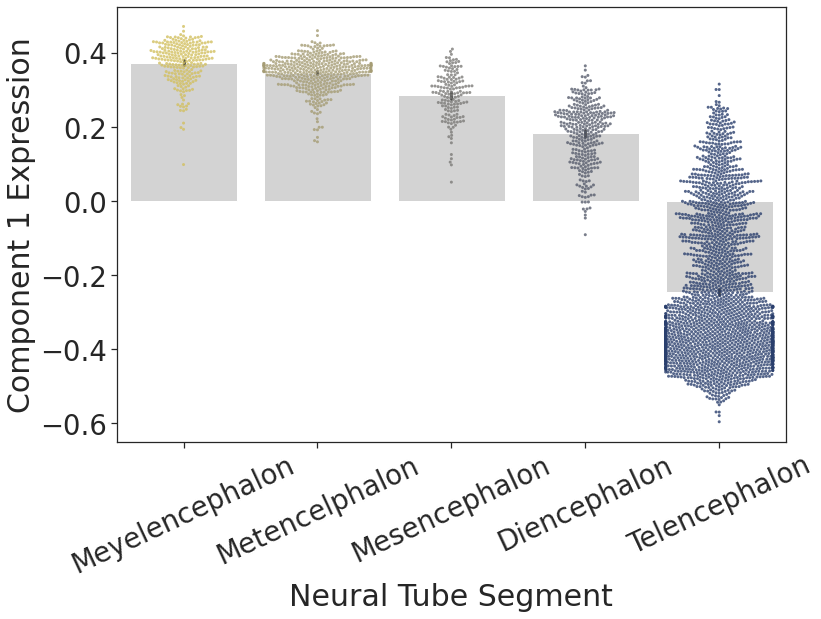

In [41]:
# C1
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='C1_Expression', 
            data=gdf,color='lightgray',
           order = order)
g=sns.swarmplot(x='Neural_Tube_segment', y='C1_Expression', 
              data=gdf, size=3,alpha=0.8,
              order = order, palette='cividis_r')
g.set_xticklabels(order,rotation=25)
plt.xlabel('Neural Tube Segment')
plt.ylabel('Component 1 Expression')
#plt.savefig(os.path.join(fig_dir,'C1_NT.png'),bbox_inches='tight')

/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, '')

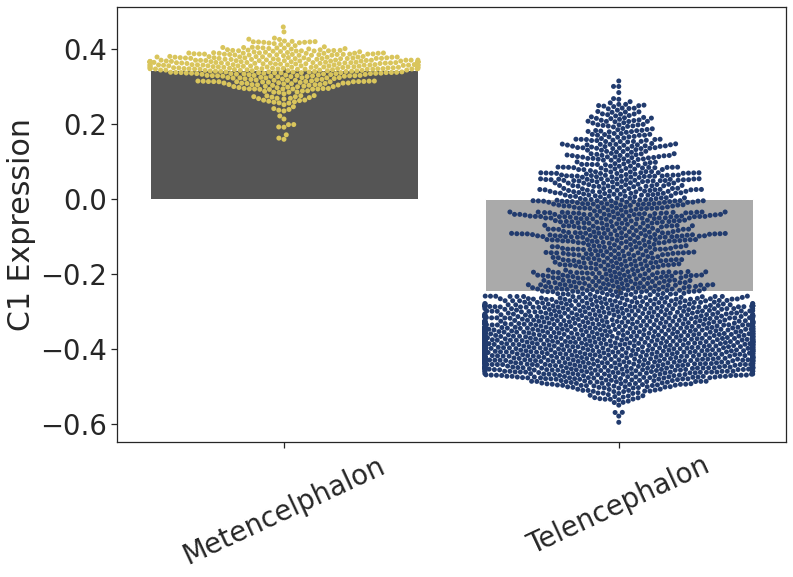

In [42]:
# Just cortex and cerebellum
rbpal = [sns.color_palette('cividis')[-1],
                      sns.color_palette('cividis')[0]]
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Metencelphalon','Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='C1_Expression', 
            data=gdf[gdf.Neural_Tube_segment.isin(order)],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='Neural_Tube_segment', y='C1_Expression', 
              data=gdf[gdf.Neural_Tube_segment.isin(order)], 
              order = order, palette=rbpal)
g.set_xticklabels(order,rotation=25)
plt.ylabel('C1 Expression')
plt.xlabel('')
#plt.savefig(os.path.join(fig_dir,'BSComp_ABA_C1.png'),bbox_inches='tight')


/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Component 1 Expression')

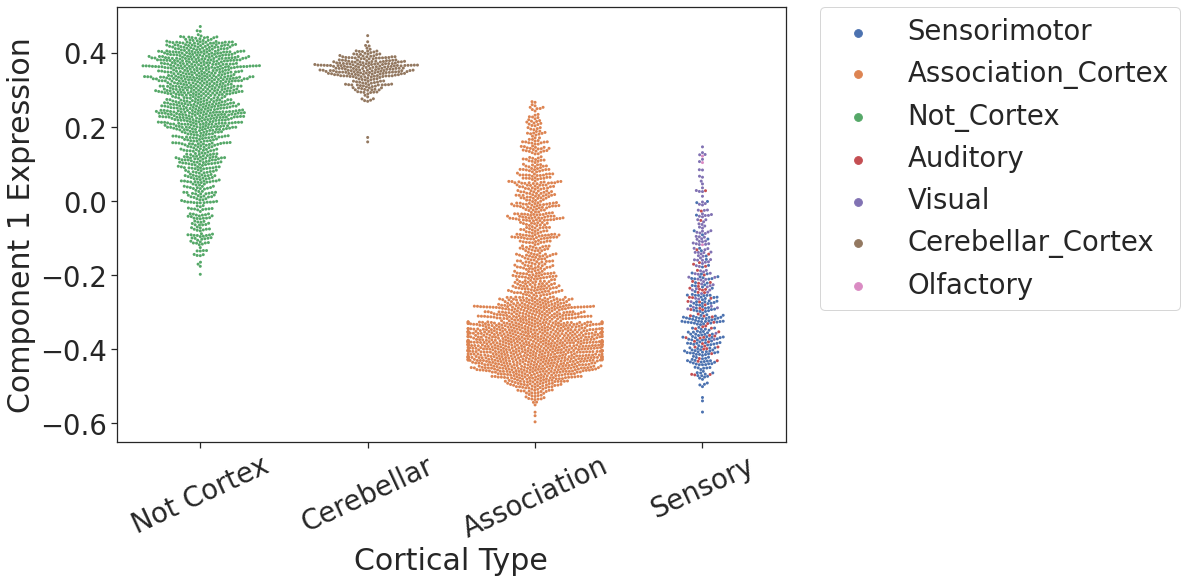

In [43]:
# C1 Cortical types
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='C1_Expression', data=gdf, size=3,
                hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 1 Expression')
#plt.savefig(os.path.join(fig_dir,'C1_Modals.png'),bbox_inches='tight')

/cbica/home/bertolem/anaconda3/envs/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'Meyelencephalon'),
 Text(1, 0, 'Metencelphalon'),
 Text(2, 0, 'Mesencephalon'),
 Text(3, 0, 'Diencephalon')]

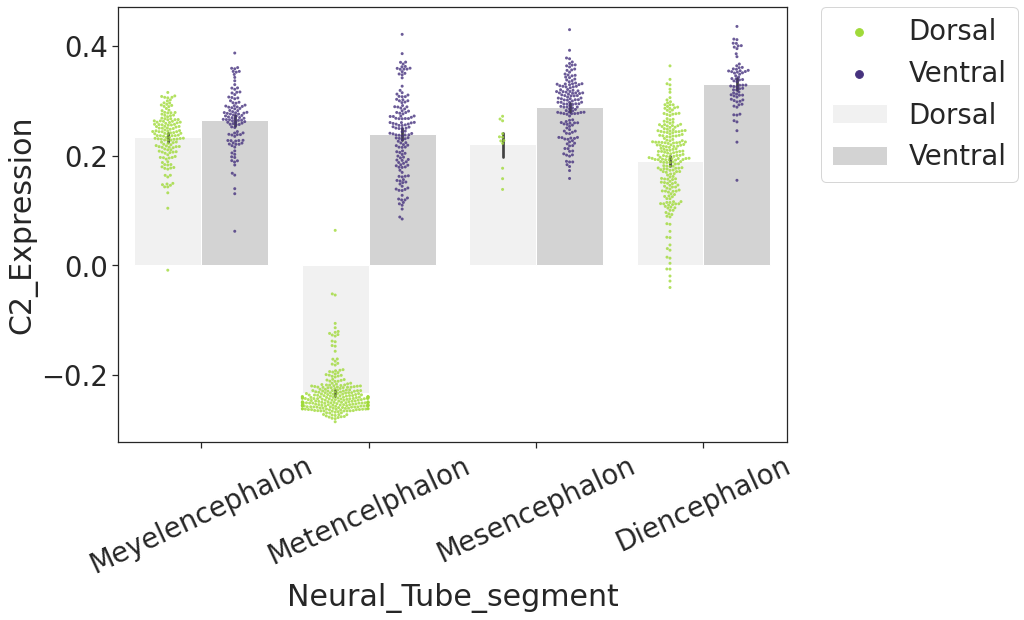

In [44]:
# C2
rbpal = [sns.color_palette('viridis')[-1],
                      sns.color_palette('viridis')[0]]
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon']
horder = ['Dorsal','Ventral']
sns.barplot(x='Neural_Tube_segment', y='C2_Expression', 
            data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
            color='lightgray',hue='Neural_Plate',
           order = order,hue_order=horder)
g=sns.swarmplot(x='Neural_Tube_segment', y='C2_Expression', 
              data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
                hue='Neural_Plate',dodge=True,size=3,alpha=0.8,
              order = order, palette=rbpal,hue_order=horder,
               )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
#plt.savefig(os.path.join(fig_dir,'C2_NT-NoTele.png'),bbox_inches='tight')

Text(0.5, 0, 'Telencephalon')

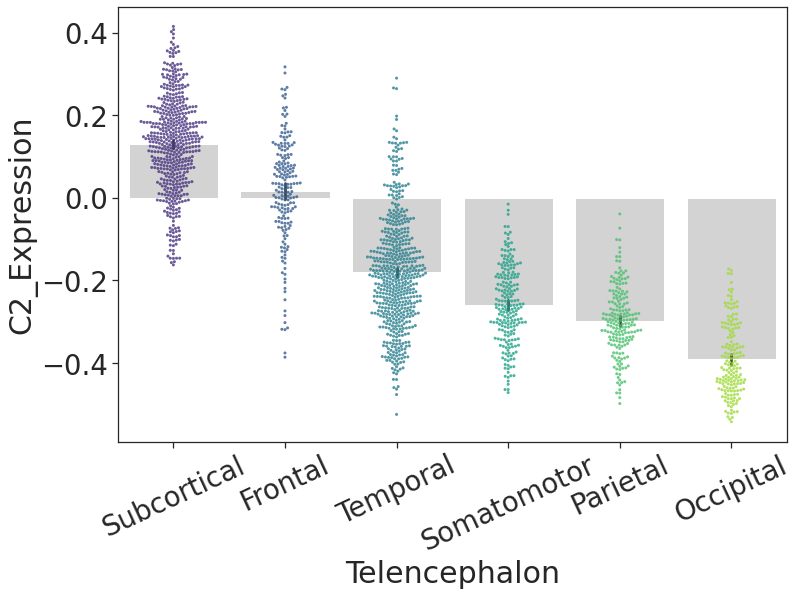

In [45]:
# C2
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Subcortical', 'Frontal', 'Temporal','Somatomotor', 
         'Parietal','Occipital']
sns.barplot(x='Neural_Plate', y='C2_Expression', 
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
            color='lightgray',
           order = order,
            hue_order=order
           )
g=sns.swarmplot(x='Neural_Plate', y='C2_Expression', 
              data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
              order = order, size=3,
                palette='viridis',alpha=0.8)
g.set_xticklabels(order,rotation=25)
plt.xlabel('Telencephalon')
#plt.savefig(os.path.join(fig_dir,'C2_NT-TeleOnly.png'),bbox_inches='tight')

Text(0, 0.5, 'Component 2 Expression')

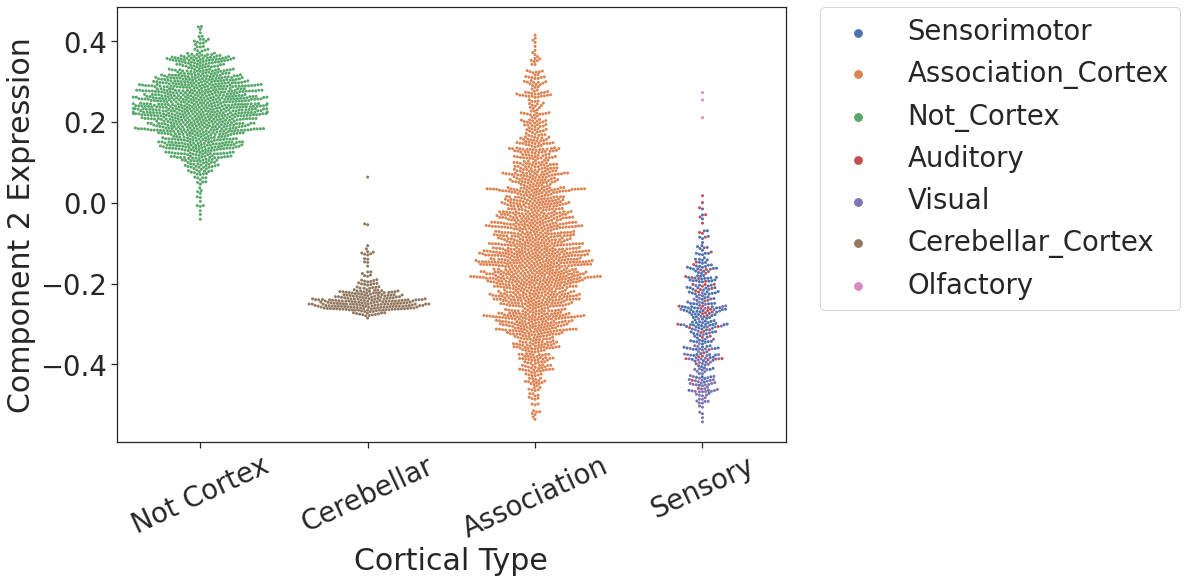

In [46]:
# C2 Cortical types
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='C2_Expression', data=gdf, size=3,
                hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 2 Expression')
#plt.savefig(os.path.join(fig_dir,'C2_Modals.pdf'),bbox_inches='tight')

Text(0, 0.5, 'Component 3 Expression')

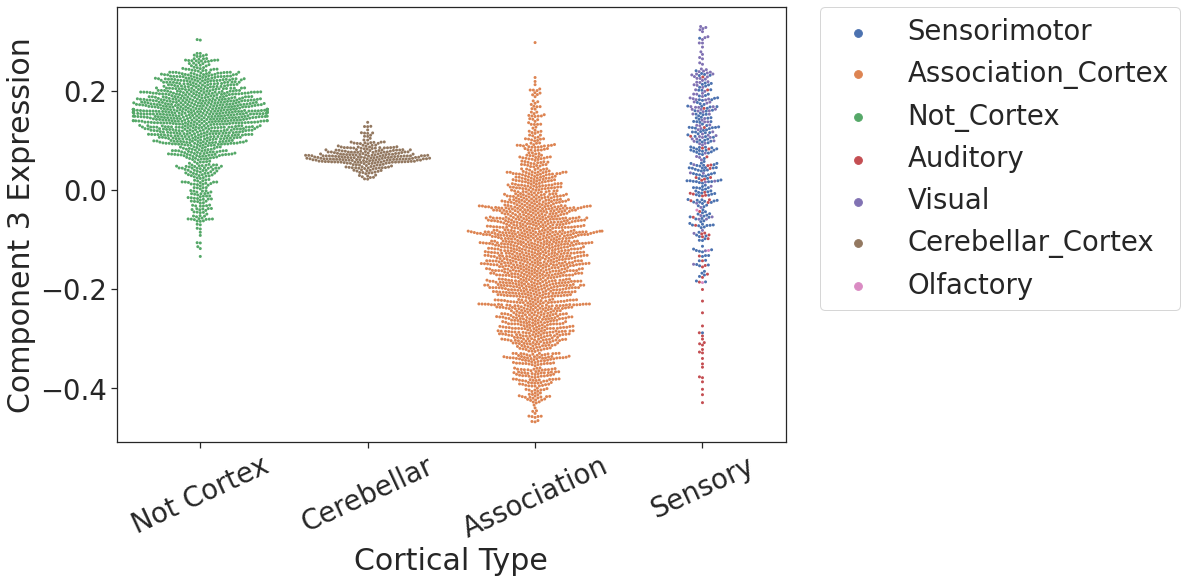

In [47]:
# C3 Cortical types
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g = sns.swarmplot(x='Cortical_Type', y='C3_Expression',size=3, 
              data=gdf, hue='Sensory_Type',order=order,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 3 Expression')
#plt.savefig(os.path.join(fig_dir,'C3_Modals.pdf'), bbox_inches='tight')

# Save data for other notebooks

#### Data for Brainspan and GTex validation
Here we are calculating component expression for each major brain division, for each component

In [48]:
for i in range(1,4):
    c_vals = pandas.pivot_table(gdf,values='C%s_Expression'%i,
                                 index='brain_divison',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = gdf[gdf.brain_divison==div]['C%s_Expression'%i
                                         ].sem()
        c_vals.loc[div,'sem'] = sem
    c_vals.to_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%i)


In [49]:
c_vals

,C3_Expression,sem
brain_divison,,
Alar_Medulla,0.166156,0.003980
Anterior_Cingulate,-0.179768,0.009506
Basal_Medulla,0.152963,0.003534
Cerebellum,0.067672,0.001231
DCN,0.201796,0.005652
Forebrain,0.028713,0.012785
Frontal,-0.168400,0.004311
Hypothalamus,0.097335,0.004446
Insula,-0.184106,0.012062


In [50]:
### same thing for GTeX
for i in range(1,4):
    c_vals = pandas.pivot_table(gdf,values='C%s_Expression'%i,
                                 index='GTeX_div',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = gdf[gdf.GTeX_div==div]['C%s_Expression'%i
                                         ].sem()
        c_vals.loc[div,'sem'] = sem
    c_vals.to_csv('data/GCorr_GTexComp_ABA_C%s_data.csv'%i)


#### Supp table

In [51]:
cols = ['donor', 'sample', 'structure_id', 'slab_num', 'well_id', 'slab_type',
       'structure_acronym', 'structure_name','brain_divison','Neural_Tube_segment', 'Cortical_Type',
       'Sensory_Type', 'Neural_Plate', 'GTeX_div']

In [52]:
gdf[cols].to_csv('./tables/structure_labels.csv')

#### PCs
This data is for the XSpecies notebook

In [53]:
pca_tfm.shape

(3466, 100)

In [54]:
gdf.shape

(3466, 45)

In [55]:
allpcs = []
for pc in range(pca_tfm.shape[1]):
    gdf.loc[:,'PC'] = pca_tfm.loc[:,pc]
    c_vals = pandas.pivot_table(gdf,values='PC',
                                 index='brain_divison',aggfunc=np.mean
                                )
    c_vals.columns = ['PC%s'%pc]
    allpcs.append(c_vals)
allpcs = pandas.concat(allpcs,axis=1)

In [56]:
allpcs.to_csv('./data/Allen_Macrostructure_PCs.csv')

In [57]:
compmat = pandas.DataFrame(pcamod.components_,
                           index = ['C%s'%x for x in range(len(pcamod.components_))],
                           columns = bigdf.columns).T

In [58]:
compmat.to_csv('./data/Allen_PC_matrix.csv')